In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost as xgb
from sklearn import model_selection, preprocessing
color = sns.color_palette()
%matplotlib inline
# result transform
def num2log(arr):
    return np.log(arr + 1)
# result retransform
def log2num(arr):
    return np.exp(arr) - 1
# treat date
def trans_date(arr): 
    return datetime.datetime.strptime(arr, '%Y-%m-%d').date()

In [2]:
import pandas as pd
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = "/content/drive/MyDrive/Magistrale/AI in Industry/new_data"
map_data = {}
size = 2

In [6]:
def read_df(file_name):
    '''
    Read the dataframe, given a file_name
    '''
    df = pd.read_parquet(file_name)
    return df


i=0
for file_name in os.listdir(data_dir):
    file_name = data_dir+'/'+file_name
    df = read_df(file_name)
    map_data[file_name]=df
    i+=1
    if i==size:
        break

In [7]:
df = map_data["/content/drive/MyDrive/Magistrale/AI in Industry/new_data/r205n12.gzip"]
y_current = df["label"]
y_new = df["New_label"]

In [8]:
df_normalized = df[df.columns.drop(list(df.filter(regex='var')))]
df_normalized = df_normalized[df_normalized.columns.drop(list(df_normalized.filter(regex='max')))]
df_normalized = df_normalized[df_normalized.columns.drop(list(df_normalized.filter(regex='min')))]
df_normalized = df_normalized.drop(['label', 'New_label'], axis=1)
df_normalized = df_normalized.set_index('timestamp')

In [10]:
description = df_normalized.describe().transpose()
print(description.loc[description['std'] <= 1])
delete = description.loc[description['std'] == 0].index.values.tolist()
df_normalized = df_normalized.drop(delete, axis=1)

                        count          mean       std           min  \
avg:fan_disk_power    13243.0  3.247872e+01  0.700757  2.800000e+01   
avg:gv100card0        13243.0  0.000000e+00  0.000000  0.000000e+00   
avg:gv100card1        13243.0  0.000000e+00  0.000000  0.000000e+00   
avg:gv100card3        13243.0  0.000000e+00  0.000000  0.000000e+00   
avg:gv100card4        13243.0  0.000000e+00  0.000000  0.000000e+00   
avg:p0_io_power       13243.0  5.641095e+01  0.407603  5.473333e+01   
avg:p0_mem_power      13243.0  1.827345e+01  0.406749  1.800000e+01   
avg:p1_io_power       13243.0  5.281553e+01  0.757296  5.080000e+01   
avg:p1_mem_power      13243.0  1.803103e+01  0.154963  1.800000e+01   
avg:ps0_output_volta  13243.0  1.229785e+01  0.019268  1.210000e+01   
avg:ps1_output_volta  13243.0  1.236976e+01  0.591815  0.000000e+00   
avg:cpu_aidle         13243.0  9.997630e+01  0.045723  9.923333e+01   
avg:cpu_idle          13243.0  9.996588e+01  0.389446  8.730000e+01   
avg:cp

In [15]:
df_normalized = (df_normalized - df_normalized.mean())/df_normalized.std()

In [16]:
print('In the dataset, there are {} rows and {} columns after clearing feature with std==0'.format(df_normalized.shape[0],df_normalized.shape[1]))

In the dataset, there are 13243 rows and 104 columns after clearing feature with std==0


In [30]:
missing = df_normalized.isnull().sum(0).reset_index()
missing.columns = ['column', 'count']
missing = missing.sort_values(by = 'count', ascending = False).loc[missing['count'] > 0]
missing['percentage'] = missing['count'] / float(df_normalized.shape[0]) * 100
print(missing)

Empty DataFrame
Columns: [column, count, percentage]
Index: []


No missing values as expected, let's try the pearson correlation

In [ ]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

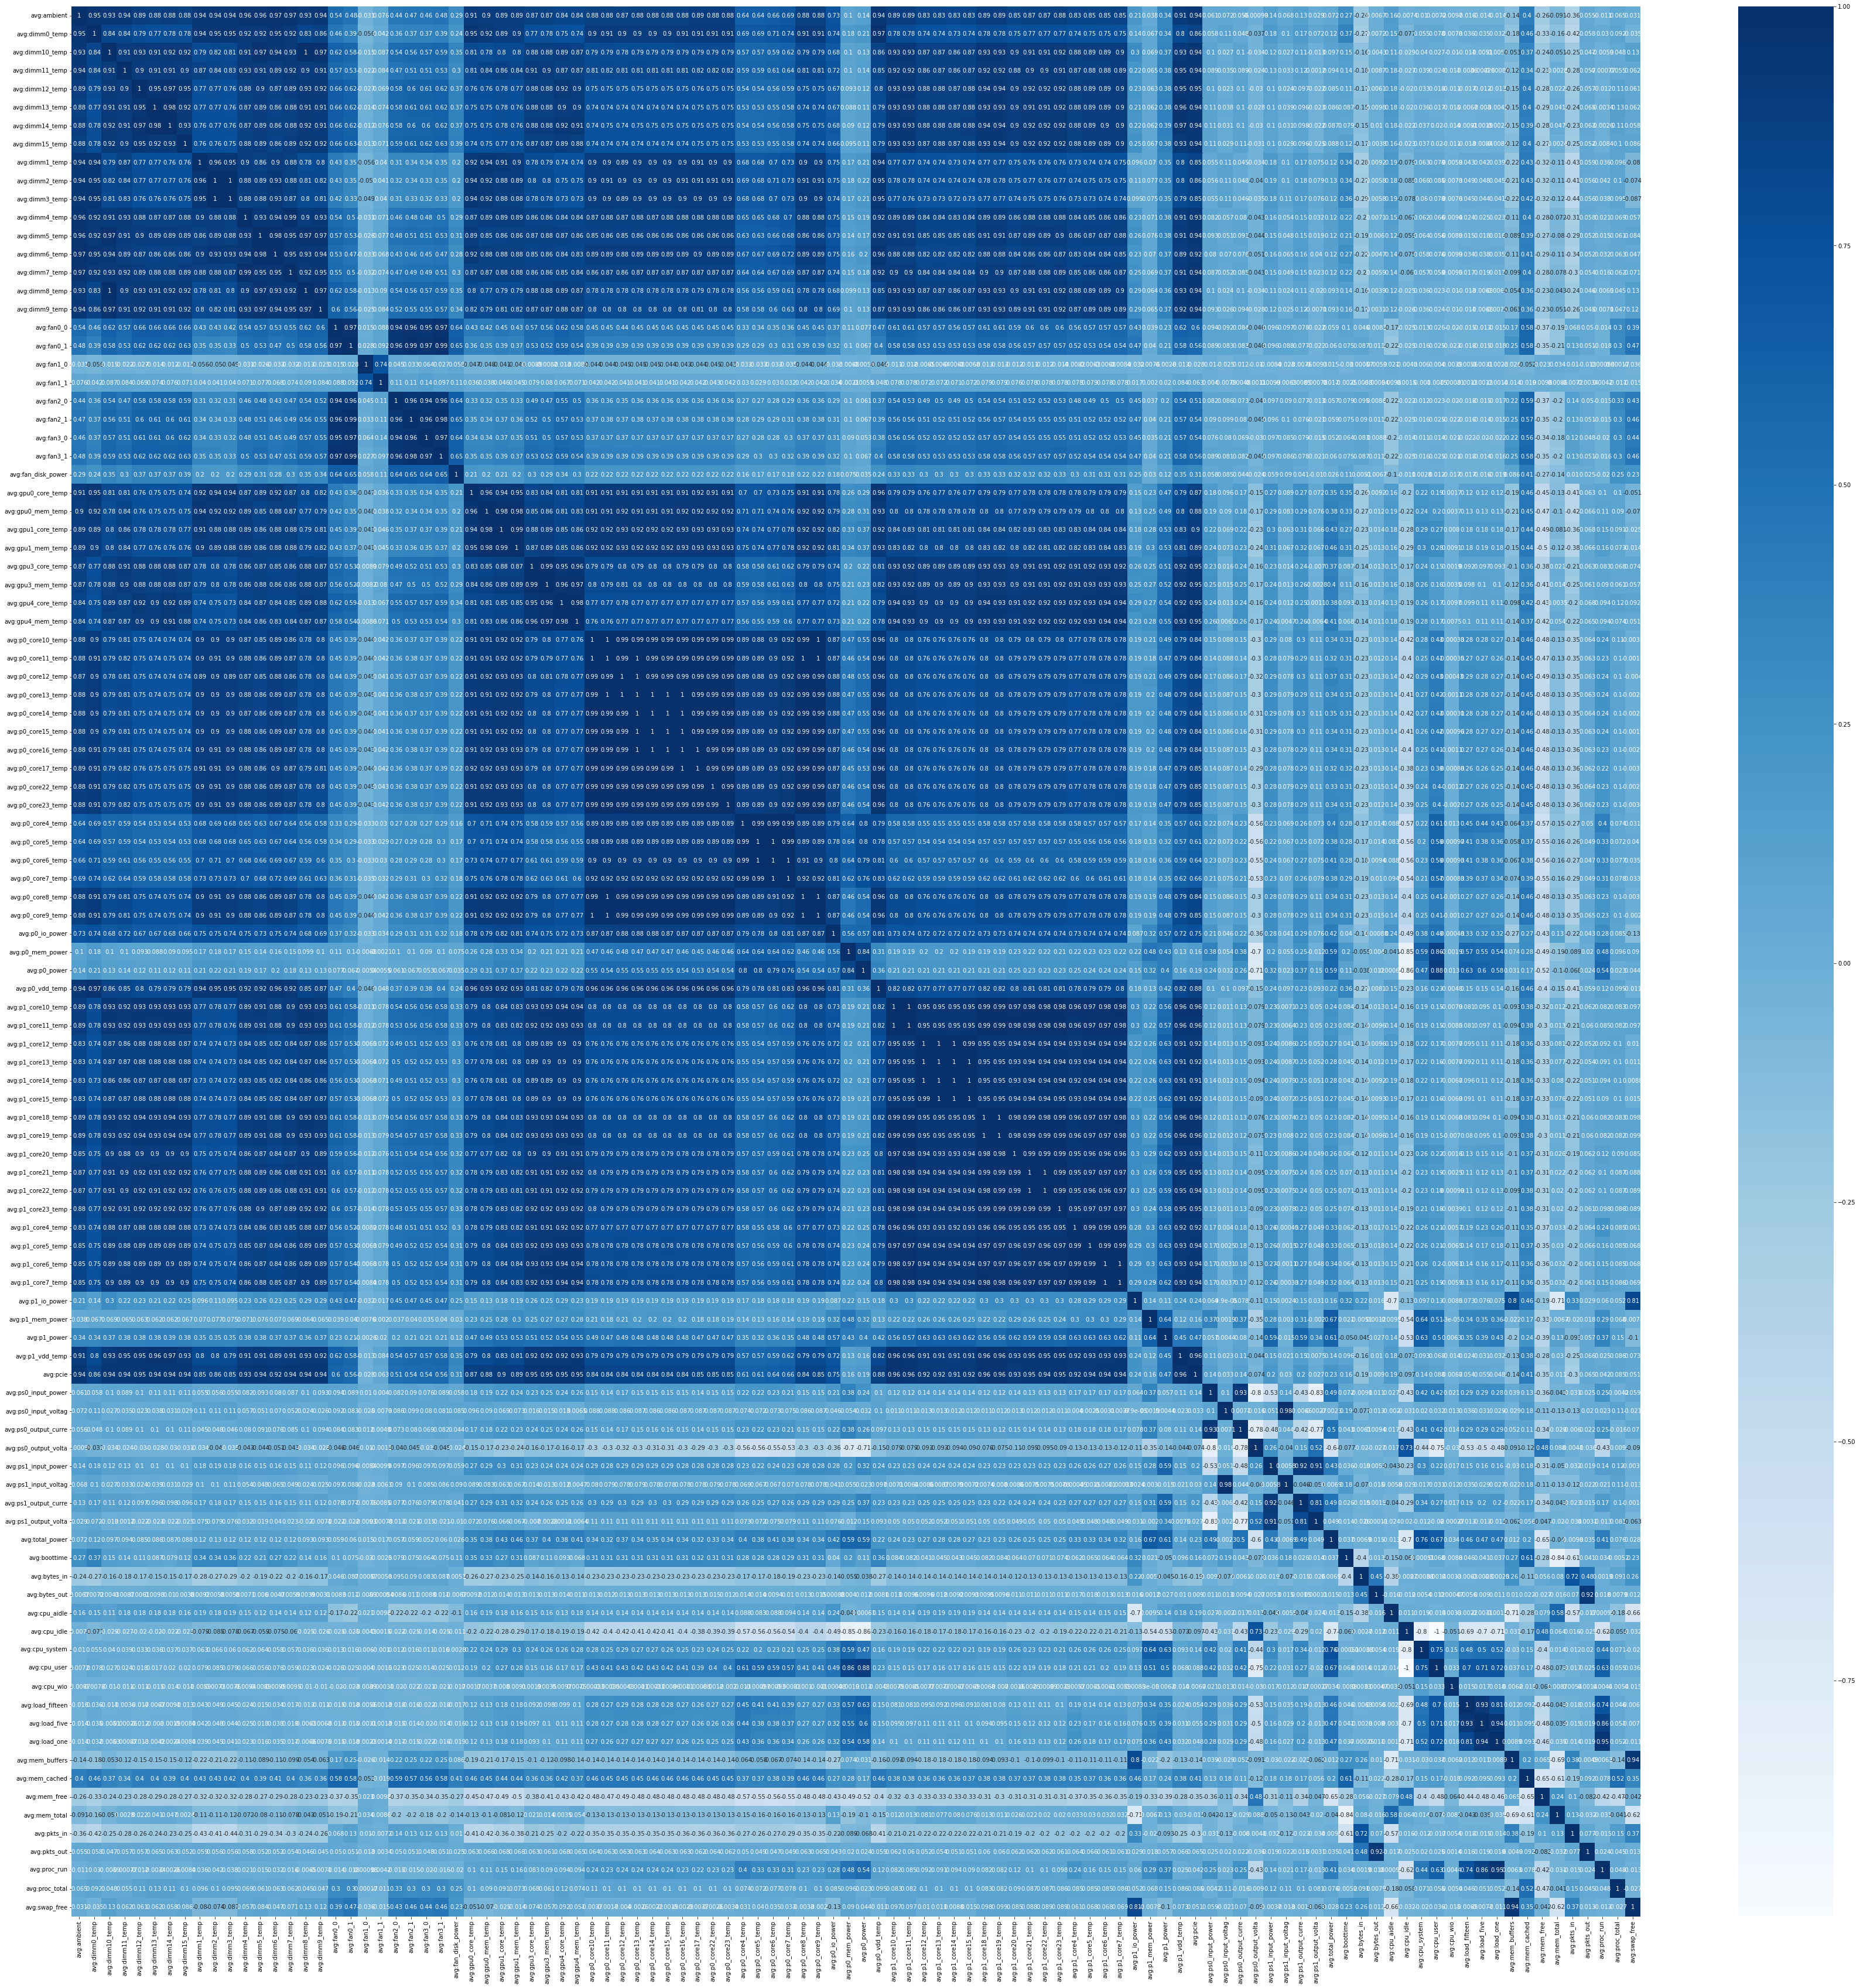

In [35]:
plt.figure(figsize=(60,60))
cor = df_normalized.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [18]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [22]:
corr_features = correlation(df_normalized, 0.9)
print(len(set(corr_features)))
print(corr_features)

73
{'avg:proc_run', 'avg:load_five', 'avg:dimm4_temp', 'avg:fan2_1', 'avg:dimm6_temp', 'avg:p1_core13_temp', 'avg:p1_core4_temp', 'avg:dimm2_temp', 'avg:p1_core14_temp', 'avg:p0_core9_temp', 'avg:fan3_0', 'avg:p1_core12_temp', 'avg:dimm13_temp', 'avg:ps1_output_curre', 'avg:gpu4_mem_temp', 'avg:p1_core5_temp', 'avg:pcie', 'avg:p0_core13_temp', 'avg:fan0_1', 'avg:p1_core18_temp', 'avg:cpu_user', 'avg:p0_core5_temp', 'avg:dimm0_temp', 'avg:dimm9_temp', 'avg:p0_core12_temp', 'avg:p0_core15_temp', 'avg:p1_core11_temp', 'avg:p1_core20_temp', 'avg:ps0_output_curre', 'avg:dimm10_temp', 'avg:gpu4_core_temp', 'avg:ps1_input_voltag', 'avg:dimm7_temp', 'avg:p1_core15_temp', 'avg:dimm11_temp', 'avg:fan3_1', 'avg:p0_core23_temp', 'avg:p0_core7_temp', 'avg:gpu0_core_temp', 'avg:gpu1_core_temp', 'avg:p0_core17_temp', 'avg:dimm5_temp', 'avg:fan2_0', 'avg:p1_core21_temp', 'avg:p0_core10_temp', 'avg:p1_core23_temp', 'avg:p0_core11_temp', 'avg:p1_core19_temp', 'avg:dimm1_temp', 'avg:ps1_output_volta', 'a

In [24]:
selected = df_normalized.drop(corr_features, axis=1)
print('In the dataset, there are {} rows and {} columns after clearing feature with pearson correlation > 0.9'.format(selected.shape[0],selected.shape[1]))


In the dataset, there are 13243 rows and 31 columns after clearing feature with pearson correlation > 0.9


In [25]:
for i in list(selected.columns):
  print(i)

avg:ambient
avg:fan0_0
avg:fan1_0
avg:fan1_1
avg:fan_disk_power
avg:p0_core4_temp
avg:p0_io_power
avg:p0_mem_power
avg:p0_power
avg:p1_io_power
avg:p1_mem_power
avg:p1_power
avg:ps0_input_power
avg:ps0_input_voltag
avg:ps0_output_volta
avg:ps1_input_power
avg:total_power
avg:boottime
avg:bytes_in
avg:bytes_out
avg:cpu_aidle
avg:cpu_idle
avg:cpu_system
avg:cpu_wio
avg:load_fifteen
avg:mem_buffers
avg:mem_cached
avg:mem_free
avg:mem_total
avg:pkts_in
avg:proc_total
